# PyVG: Data Science to predict Video Games sales
>Equipe: Alexis Terrasse, Henri-François Mole, Hsan Drissi, Stephane Lelievre
>
>Promo: DS_Oct21
---
## 02 - Exploratory data analysis (avec dataset plus complet)
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
sns.set_theme(color_codes=True)

In [2]:
def lire():
    df = pd.read_csv("../data/vgsales_eda2.csv", sep=",") 
    print ('dataset shape:', df.shape)
    print ('columns:', df.columns)
    df = df[(df.year>2000) & (df.year<2019) ]
    print ('dataset shape ([2001 ; 2018]):', df.shape)

    return df
#print (df.year.value_counts())
# années <= 2000 peut representative, vielles consoles, et quasi rien pour 2020 et 2019

In [3]:
def affiche_correlation(df):
    cor = df.corr()
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(cor, annot=True, ax=ax, cmap='viridis'); #viridis, coolwarm

In [4]:
# on retire les variables relatives à la date... deplus de essais de classif montre qu'ils ne servent pas à grand chose
def enlever_date_ref(df):
    df = df.drop(columns=['day', 'month', 'release_date', 'quarter'])
    return df


In [5]:
def affiche_relation(df,anom=False):
    if ('anom' not in df.columns):
        df['anom'] = 1
    sns.pairplot(data=df, hue='anom', diag_kind='hist')
    

In [6]:
#https://practicaldatascience.co.uk/machine-learning/how-to-use-the-isolation-forest-model-for-outlier-detection
from sklearn.ensemble import IsolationForest

def supprimer_val_aberrantes(df):
    isof = IsolationForest(contamination=0.02, n_estimators=100)

    if ('anom' in df.columns):
        df = df.drop(columns=['anom'])
    isof.fit(df.select_dtypes(exclude='object'))
    df['anom'] = isof.predict(df.select_dtypes(exclude='object'))
    #df[df['anom']<0].index
    
    df = df.drop(df[df['anom']<0].index)
    df = df.drop(columns=['anom'])
    
    # On ajoute également deux jeux qui sont tout seul dansleur genre !
    #i= df[df['Name']=='Minecraft'].index.to_list()
    #df.loc[i,'Genre'] = 'Action-Adventure'
    #i = df[df['Genre']=='Education'].index.to_list()
    #df.loc[i,'Genre'] = 'Misc'
    
    df = df.drop(df[df['Name']=='Minecraft'].index)
    df = df.drop(df[df['Genre']=='Education'].index)
    
    #df = df.drop(df[df['Genre']=='MMO'].index)
    #df = df.drop(df[df['Genre']=='Party'].index)
    #df = df.drop(df[df['Genre']=='Visual+Novel'].index)
    
    return df


In [7]:
# Pour simplifier l'analyse des plateformes, nous regroupons les plateformes
def OEM(r):
    oem = 'Others'
    if r['Platform'] in ['X360',  'XB', 'XOne']:
        oem = "xbox"
    elif r['Platform'] in ['PS', 'PS2', 'PS3', 'PS4', 'PSP', "PSV"]:
        oem = "playstation"
    elif r['Platform'] in ['Wii', 'WiiU', 'N64', 'GC', 'NS', "3DS", 'DS']:
        oem = "nintendo"
    elif r['Platform'] in ['PC']:
        oem = "PC"
    return oem

def ajoute_oem(df):
    df['oem'] = df.apply(OEM,axis=1)
    return df

def ajoute_dummies(df):
    df = df.join(pd.get_dummies(df.oem,drop_first=True))
    
    # On recup les 12 top Publisher
    publisher_list = df.Publisher.value_counts().head(12).index.tolist()
    df['Publisher_top'] = df.apply(lambda r: r['Publisher'] if r['Publisher'] in publisher_list else 'Others', axis=1)
    df = df.join(pd.get_dummies(df.Publisher_top,drop_first=True,prefix='pub'))
    
    # On recup les 12 top Franchises
    franchise_list = df.Franchise_wikipedia.value_counts().head(12).index.tolist()
    df['Franchise_top'] = df.apply(lambda r: r['Franchise_wikipedia'] if r['Franchise_wikipedia'] in franchise_list else 'Others', axis=1)
    df = df.join(pd.get_dummies(df.Franchise_top,drop_first=True,prefix='lic'))
    
    # dummies years and genre
    df = df.join(pd.get_dummies(df.year,prefix='year.release'))
    df = df.join(pd.get_dummies(df.Genre,prefix='genre',drop_first=True))
    
    return df


In [8]:
# https://dataanalyticspost.com/Lexique/loi-gaussienne/ + article datasientest
def normalise_log(df):
    df['Global_Sales.log'] = np.log(df['Global_Sales'] * 100000 + 1)
    df['N_pro.log'] = np.log(df['N_pro']+1)
    df['N_user.log'] = np.log(df['N_user']+1)
    return df

def affiche_log(df):
    fig, axes = plt.subplots(2,3,figsize=(16,8))
    sns.histplot(data=df, x='Global_Sales',ax=axes[0][0])
    sns.histplot(data=df, x='N_pro',ax=axes[0][1])
    sns.histplot(data=df, x='N_user',ax=axes[0][2])
    sns.histplot(data=df, x='Global_Sales.log',ax=axes[1][0])
    sns.histplot(data=df, x='N_pro.log',ax=axes[1][1])
    sns.histplot(data=df, x='N_user.log',ax=axes[1][2]);   

In [9]:
def enregistrer(df):
    df.to_csv("../data/vgsales_eda2_ready.csv", sep=",", index=False)
    print ('Fichier vgsales_eda2_ready.csv sauvé')
    print (df.columns)


In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder

def affiche_pca(df,l=False,bins=8):
    col_ = ['Score_pro', 'Score_user',
            'N_pro', 'N_user', 'compound',
            'N_pro.log', 'N_user.log',
            'year','compound',
            'N_pro.log', 'N_user.log',
            'PC', 'nintendo', 'playstation', 'xbox',
           # 'labels'
           ]  
    
    #target = pd.qcut(df['Global_Sales'],q=bins, labels=[i for i in range(0,bins)]).astype('int64')
    if l:
        target = pd.qcut(df['Global_Sales.log'],q=bins)
    else:
        target = pd.qcut(df['Global_Sales'],q=bins)
    
    df2 = df[col_].copy()
    
    scaler = StandardScaler()
    scaled_df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

    pca = PCA (n_components=0.9) #n_components = 3)
    data_2D = pca.fit_transform(scaled_df2)
    #print ("Explained variance", pca.explained_variance_ratio_)
    
    oem_enc = LabelEncoder()
    #x = oem_enc.fit_transform(df['oem'])
    x = oem_enc.fit_transform(target)
    
    fig, ax = plt.subplots(figsize=(12,8))
    scatter = ax.scatter(data_2D[:, 0], data_2D[:, 1], c = x, cmap=plt.cm.Spectral, alpha=0.8)
    ax.set_xlabel(f'PCA 1 ({np.round(pca.explained_variance_ratio_[0],2)}%)')
    ax.set_ylabel(f'PCA 2 ({np.round(pca.explained_variance_ratio_[1],2)}%)')
    ax.set_title("Données projetées sur les 2 axes de PCA")

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    #ax.add_artist(legend1)
    
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend2 = ax.legend(handles, oem_enc.classes_.tolist(), loc="upper right", title="Sales")
        
    plt.show();

In [51]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

def affiche_pca3D(df,l=False,bins=8):
    col_ = ['Score_pro', 'Score_user',
            'N_pro', 'N_user', 'compound',
            'N_pro.log', 'N_user.log',
            'year','compound',
            'N_pro.log', 'N_user.log',
            'PC', 'nintendo', 'playstation', 'xbox',
           # 'labels'
           ]  

    #target = pd.qcut(df['Global_Sales'],q=bins, labels=[i for i in range(0,bins)]).astype('int64')
    if l:
        target = pd.qcut(df['Global_Sales.log'],q=bins)
    else:
        target = pd.qcut(df['Global_Sales'],q=bins)
    
    df2 = df[col_].copy()
    
    scaler = StandardScaler()
    scaled_df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

    pca = PCA (n_components=0.9) #n_components = 3)
    data_2D = pca.fit_transform(scaled_df2)
    #print ("Explained variance", pca.explained_variance_ratio_)
    
    oem_enc = LabelEncoder()
    #x = oem_enc.fit_transform(df['oem'])
    x = oem_enc.fit_transform(target)
    
    X, Y, Z = axes3d.get_test_data(0.1)
    
    #fig, ax = plt.subplots(figsize=(12,8)).gca(projection='3d')
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
        
    scatter = ax.scatter(data_2D[:, 0], data_2D[:, 1], data_2D[:, 3],  c = x, cmap=plt.cm.Spectral, alpha=0.5)
    ax.set_xlabel(f'PCA 1 ({np.round(pca.explained_variance_ratio_[0],2)}%)')
    ax.set_ylabel(f'PCA 2 ({np.round(pca.explained_variance_ratio_[1],2)}%)')
    ax.set_zlabel(f'PCA 3 ({np.round(pca.explained_variance_ratio_[2],2)}%)')

    ax.set_title("Données projetées sur les 3 axes de PCA")

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    #ax.add_artist(legend1)
    
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend2 = ax.legend(handles, oem_enc.classes_.tolist(), loc="upper right", title="Sales")
        
    # rotate the axes and update
    #for angle in range(0, 360):
    #    ax.view_init(30, angle)
    #    plt.draw();
    #    plt.pause(.001)
    
    plt.show();
    


<IPython.core.display.Javascript object>


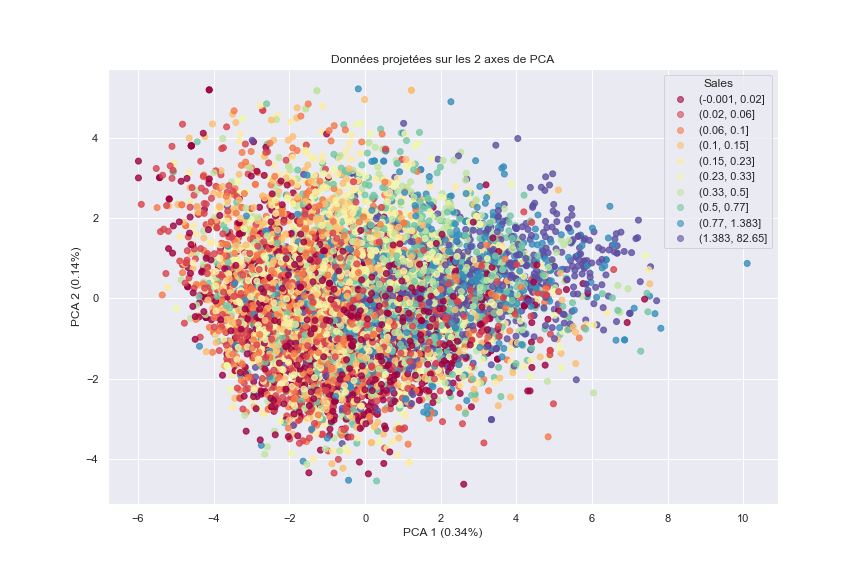

In [56]:
affiche_pca(df,bins=10)

<IPython.core.display.Javascript object>


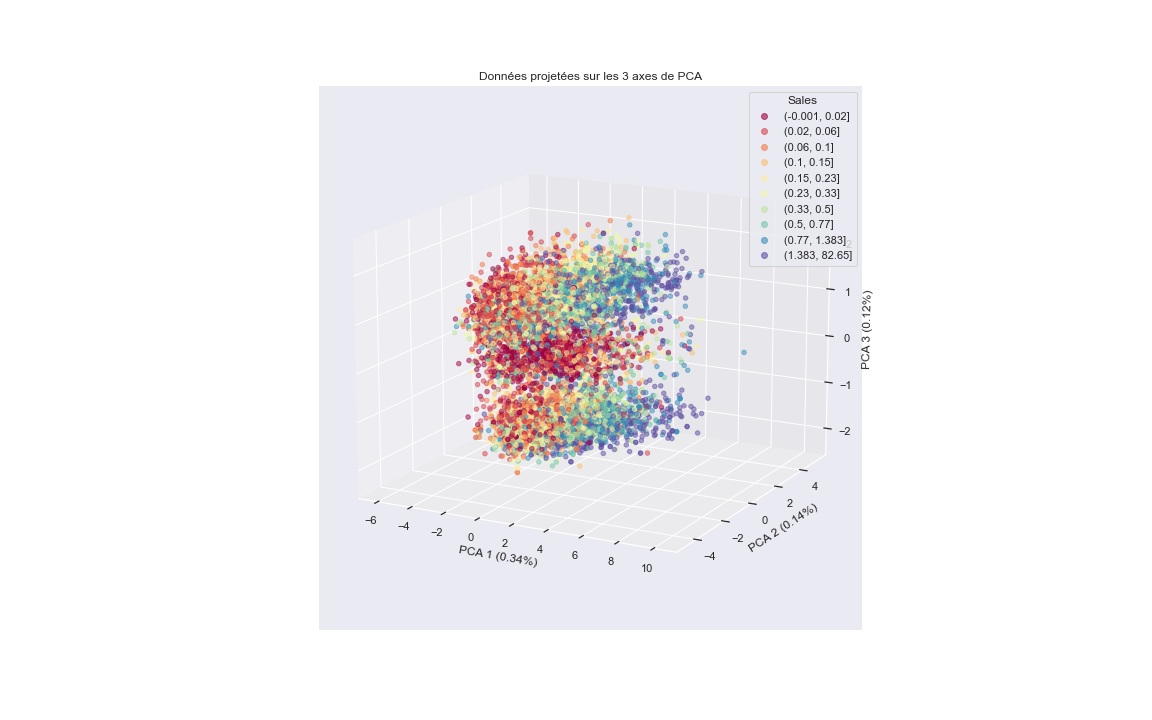

<ipython-input-51-bb7712ea29a1>:36: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


In [57]:
affiche_pca3D(df,bins=10)

In [11]:
def affiche_pca_genre(df):
    col_ = ['Score_pro', 'Score_user',
            'N_pro', 'N_user', 'compound',
            'N_pro.log', 'N_user.log',
            'year','compound',
            'N_pro.log', 'N_user.log',
            'PC', 'nintendo', 'playstation', 'xbox',
            'labels'
           ]  
        
    df2 = df[col_].copy()
    
    scaler = StandardScaler()
    scaled_df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

    pca = PCA (n_components=0.9) #n_components = 3)
    data_2D = pca.fit_transform(scaled_df2)
    #print ("Explained variance", pca.explained_variance_ratio_)
    
    oem_enc = LabelEncoder()
    x = oem_enc.fit_transform(df['Genre'])
    
    fig, ax = plt.subplots(figsize=(12,8))
    scatter = ax.scatter(data_2D[:, 0], data_2D[:, 1], c = x, cmap=plt.cm.Spectral, alpha=0.8)
    ax.set_xlabel(f'PCA 1 ({np.round(pca.explained_variance_ratio_[0],2)}%)')
    ax.set_ylabel(f'PCA 2 ({np.round(pca.explained_variance_ratio_[1],2)}%)')
    ax.set_title("Données projetées sur les 2 axes de PCA")

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    #ax.add_artist(legend1)
    
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend2 = ax.legend(handles, oem_enc.classes_.tolist(), loc="upper right", title="Genres")
        
    plt.show();

In [12]:
from sklearn.cluster import KMeans

def affiche_pca_cluster(df,c=5):
    col_ = ['Score_pro', 'Score_user',
            'N_pro', 'N_user', 'compound',
            'N_pro.log', 'N_user.log',
            'year','compound',
            'N_pro.log', 'N_user.log',
            'PC', 'nintendo', 'playstation', 'xbox',
           ]  

    df2 = df[col_].copy()
    scaler = StandardScaler()
    scaled_df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

    kmeans = KMeans(n_clusters = c)
    kmeans.fit(scaled_df2)
    labels = kmeans.labels_
    
    pca = PCA (n_components=0.9) #n_components = 3)
    data_2D = pca.fit_transform(scaled_df2)
    #print ("Explained Variance", pca.explained_variance_ratio_)
    
    fig, ax = plt.subplots(figsize=(12,8))
    scatter = ax.scatter(data_2D[:, 0], data_2D[:, 1], c = labels, cmap=plt.cm.Spectral, alpha=0.8)
    ax.set_xlabel(f'PCA 1 ({np.round(pca.explained_variance_ratio_[0],2)}%)')
    ax.set_ylabel(f'PCA 2 ({np.round(pca.explained_variance_ratio_[1],2)}%)')
    ax.set_title("Données projetées sur les 2 axes de PCA")

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    ax.add_artist(legend1)
    
    plt.show();
    
    df['labels'] = labels
    
    return df

dataset shape: (8937, 20)
columns: Index(['Name', 'Platform', 'Genre', 'Global_Sales', 'game_key', 'Name_meta',
       'Genre_meta', 'Score_pro', 'Score_user', 'Publisher', 'Developer',
       'N_pro', 'N_user', 'day', 'year', 'month', 'release_date', 'quarter',
       'Franchise_wikipedia', 'compound'],
      dtype='object')
dataset shape ([2001 ; 2018]): (8654, 20)


c:\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


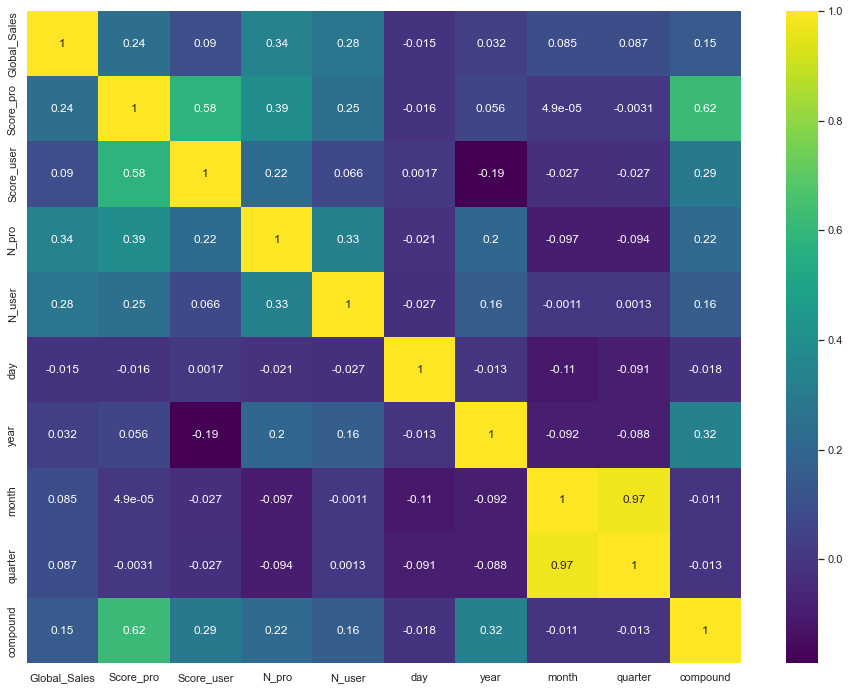

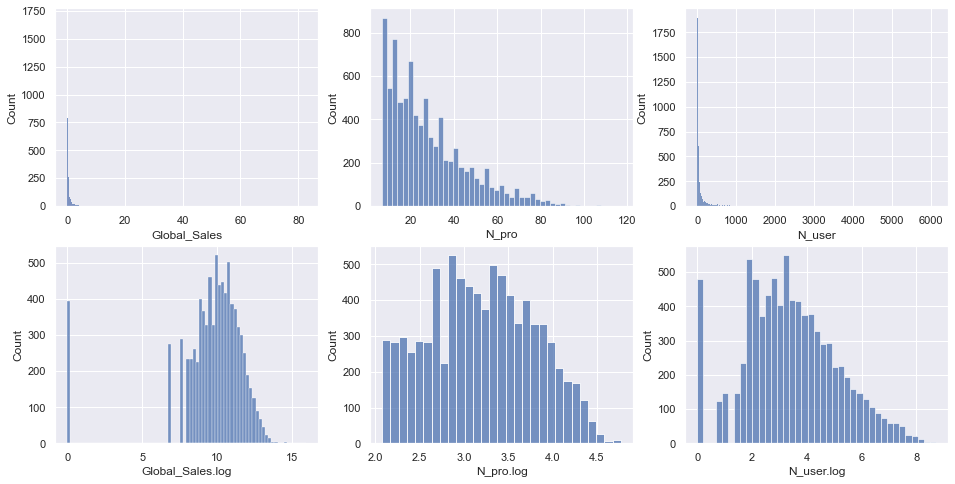

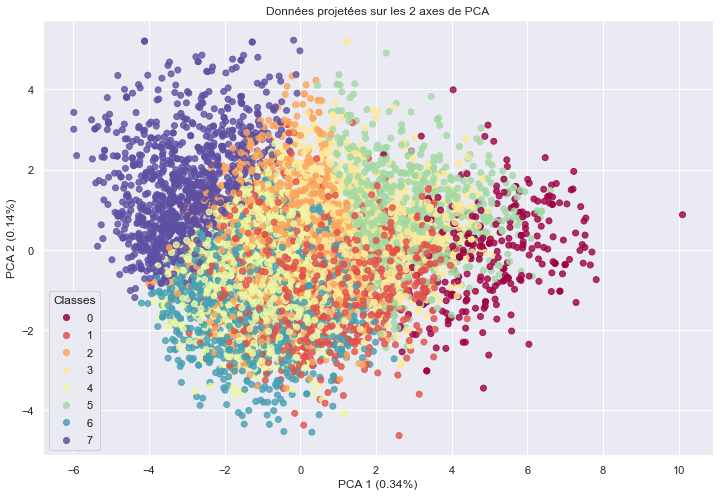

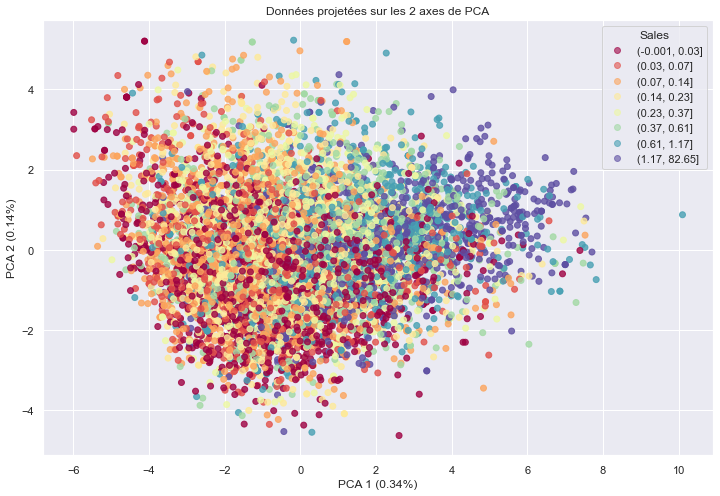

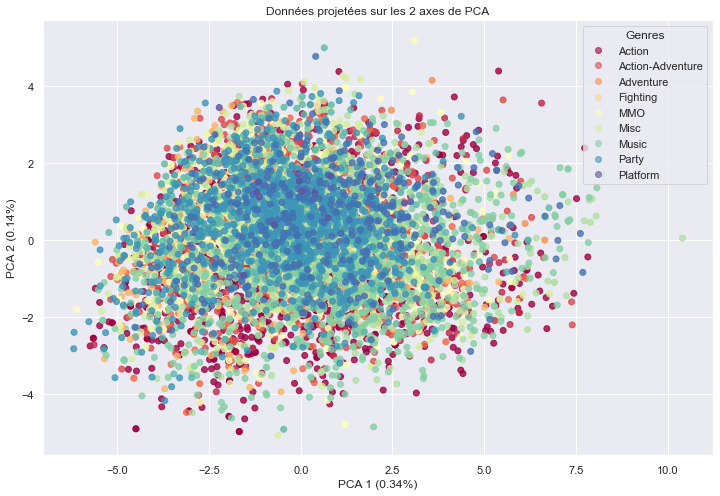

Fichier vgsales_eda2_ready.csv sauvé
Index(['Name', 'Platform', 'Genre', 'Global_Sales', 'game_key', 'Name_meta',
       'Genre_meta', 'Score_pro', 'Score_user', 'Publisher', 'Developer',
       'N_pro', 'N_user', 'year', 'Franchise_wikipedia', 'compound', 'oem',
       'Global_Sales.log', 'N_pro.log', 'N_user.log', 'PC', 'nintendo',
       'playstation', 'xbox', 'Publisher_top', 'pub_activision',
       'pub_amc games', 'pub_capcom', 'pub_ea games', 'pub_ea sports',
       'pub_electronic arts', 'pub_konami', 'pub_nintendo', 'pub_scea',
       'pub_sega', 'pub_thq', 'pub_ubisoft', 'Franchise_top', 'lic_FIFA',
       'lic_Final Fantasy', 'lic_Harry Potter', 'lic_Marvel', 'lic_NBA',
       'lic_Others', 'lic_Prince of Persia', 'lic_Sonic The Hedgehog',
       'lic_Star Wars', 'lic_The Sims', 'lic_Tom Clancy’s', 'lic_WWE',
       'year.release_2001', 'year.release_2002', 'year.release_2003',
       'year.release_2004', 'year.release_2005', 'year.release_2006',
       'year.release_2007',

In [28]:
df = lire()
affiche_correlation(df)
df = enlever_date_ref(df)
df = supprimer_val_aberrantes(df) # ici
#affiche_relation(df) # pairplot
df = ajoute_oem(df)

df = normalise_log(df)
affiche_log(df)
df = ajoute_dummies(df)
df= affiche_pca_cluster(df,8)
affiche_pca(df)
affiche_pca_genre(df)
enregistrer(df)


### test shapiro

In [14]:
from scipy import stats
shapiro_test = stats.shapiro(df['Global_Sales.log'])
shapiro_test
#Bien que le test de Shapiro avec une valeur p inférieure à 0,05 nie sa normalité,
#il est bien meilleur que les autres ventes ou les autres valeurs logarithmiques des ventes.
#Peut-être que la valeur manquante de la vente est la raison de l'anomalie.
#Nous accorderons plus d'attention à la valeur logarithmique des ventes globales plus tard.

#anderson_test = stats.anderson(df['N_pro.log'])
#anderson_test

c:\python39\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.752609372138977, pvalue=0.0)

### DataViz

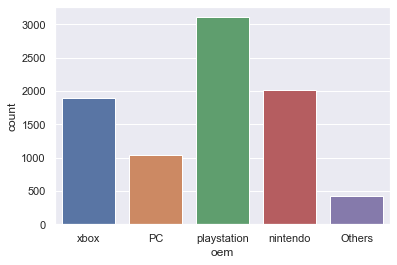

In [15]:
sns.countplot(x=df['oem']);

Playstation est le groupe le plus important, puis Xbox et Nintendo. Alors que "Autres" est le plus petit groupe

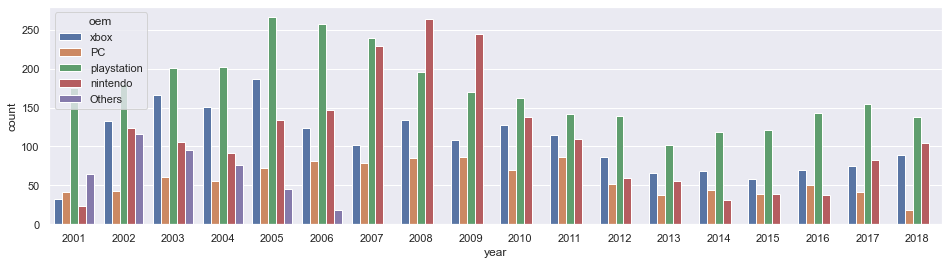

In [16]:
fig, ax = plt.subplots(figsize=(16,4))
sns.countplot(x='year',order=sorted(df.year.unique()),ax=ax,hue='oem',data=df);

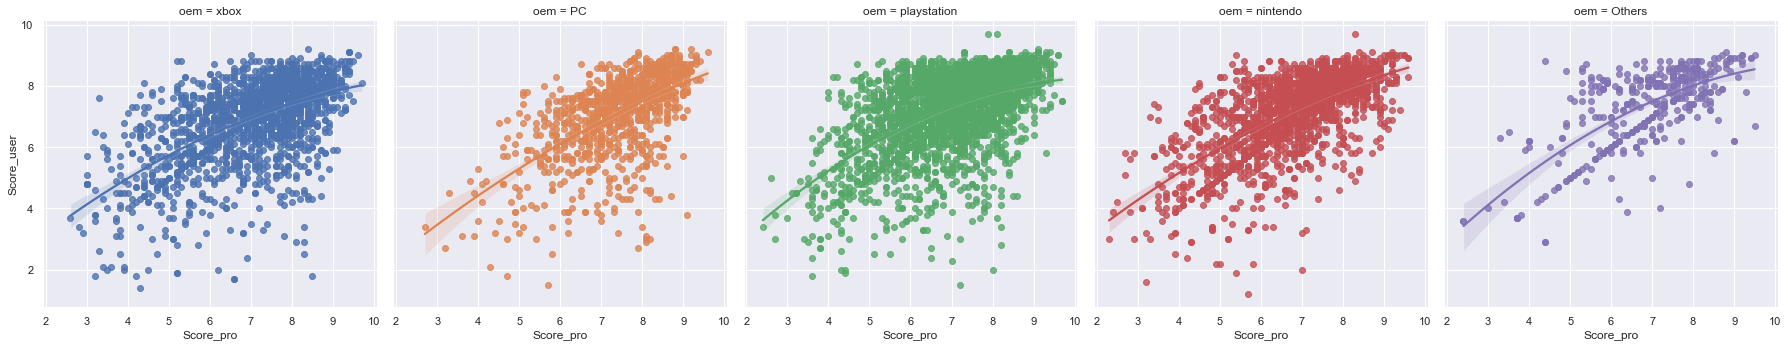

In [17]:
sns.lmplot(x='Score_pro', y='Score_user', data=df, order=2, col='oem',hue='oem', );

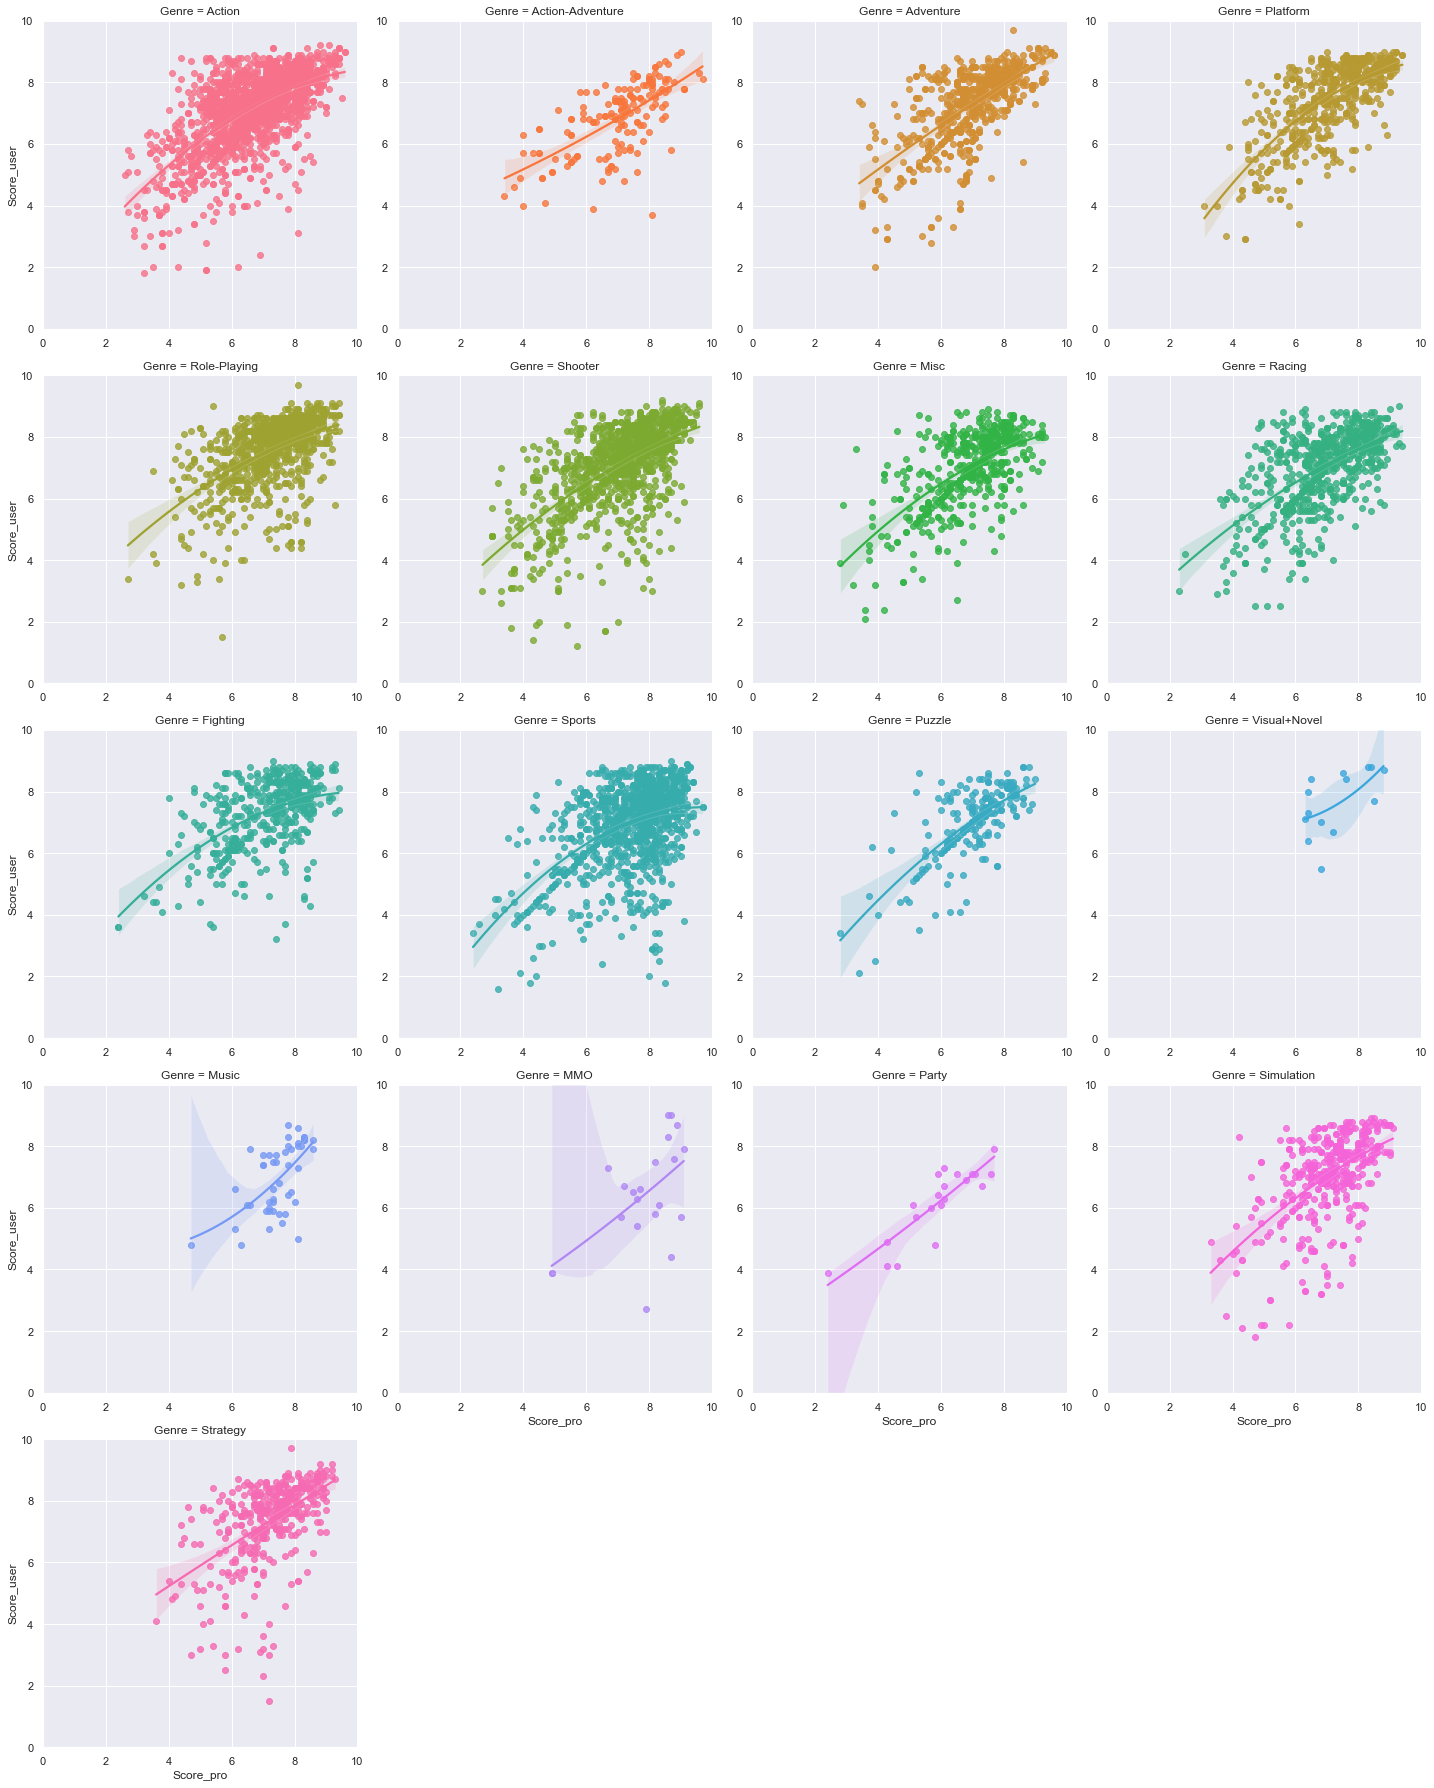

In [18]:
g = sns.lmplot(x='Score_pro', y='Score_user', data=df, order=2, col='Genre',hue='Genre', col_wrap=4, facet_kws={'sharey': False, 'sharex': False})
g.set(ylim=(0, 10))
g.set(xlim=(0, 10))

In [19]:
i= df[df['Name']=='Minecraft'].index.to_list()
df.loc[i,'Genre'] = 'Action-Adventure'

i = df[df['Genre']=='Education'].index.to_list()
df.loc[i,'Genre'] = 'Misc'

In [20]:
df[df['Name']=='Minecraft'] # --> Action-Adventure
df[df['Genre']=='Education'] # --> Misc

,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,...,genre_Platform,genre_Puzzle,genre_Racing,genre_Role-Playing,genre_Shooter,genre_Simulation,genre_Sports,genre_Strategy,genre_Visual+Novel,labels


Action              1569
Shooter             1058
Sports              1044
Role-Playing         840
Racing               628
Adventure            609
Platform             543
Misc                 478
Fighting             425
Simulation           406
Strategy             394
Puzzle               215
Action-Adventure     165
Music                 48
MMO                   21
Party                 21
Visual+Novel          14
Name: Genre, dtype: int64

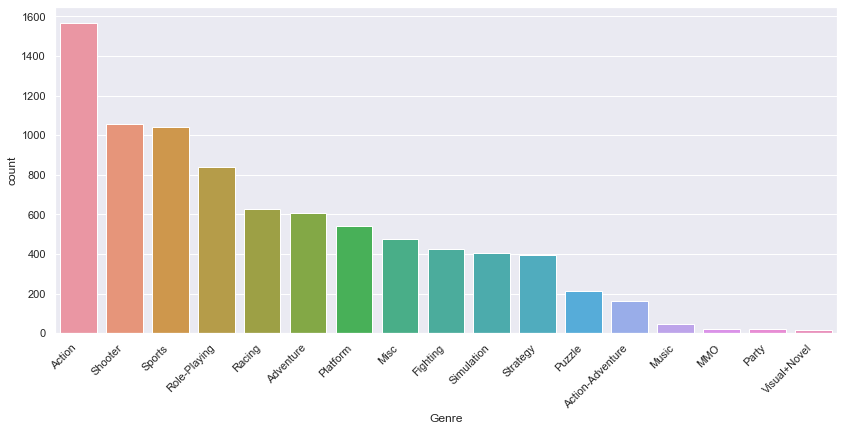

In [21]:
plt.figure(figsize=(14,6))
sns.countplot(x=df['Genre'],order=df['Genre'].value_counts().index)
plt.xticks(rotation=45,ha='right')
df['Genre'].value_counts()

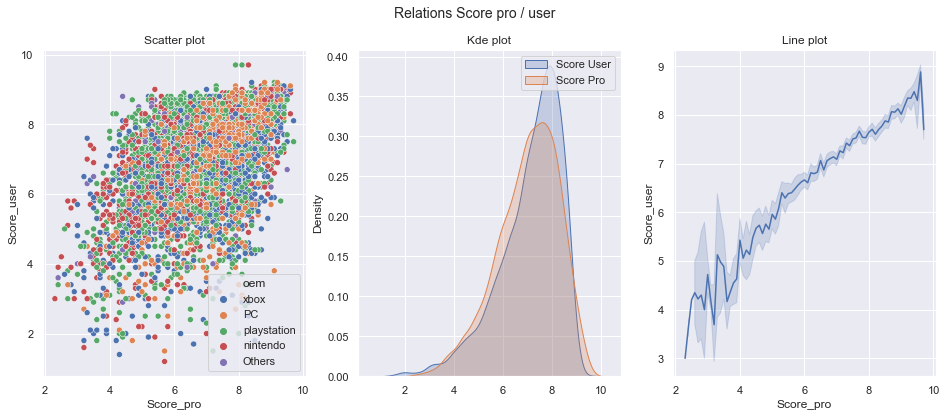

In [22]:
fig, ax = plt.subplots(figsize=(16,6),ncols=3)
fig.suptitle('Relations Score pro / user', fontsize=14)
sns.scatterplot(x='Score_pro', y='Score_user', hue='oem', data=df, ax=ax[0],  );

sns.kdeplot(df['Score_user'], ax=ax[1], fill=True )
sns.kdeplot(df['Score_pro'], ax=ax[1], fill=True);
sns.lineplot(x='Score_pro', y='Score_user', data=df, ax=ax[2]);
ax[1].legend(labels=["Score User","Score Pro"]);

ax[1].set(xlabel=None)

ax[0].set(title='Scatter plot')
ax[1].set(title='Kde plot')
ax[2].set(title='Line plot')

plt.show()
#sns.displot(df, x='Score_user',kind='kde')
#sns.displot(df, x='Score_pro',kind='kde')

Il existe une corrélation entre le score pro et le score utilisateur. 
le score pro est inférieur au score utilisateur.

           N_pro.log  Score_pro
N_pro.log   1.000000   0.389508
Score_pro   0.389508   1.000000
            N_user.log  Score_user
N_user.log     1.00000     0.23333
Score_user     0.23333     1.00000


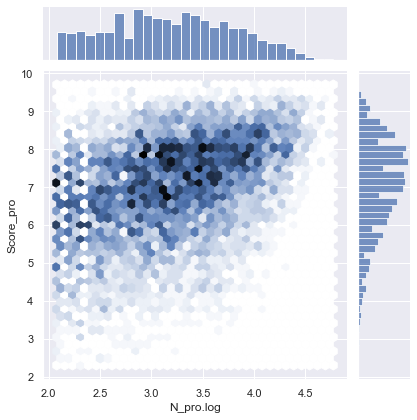

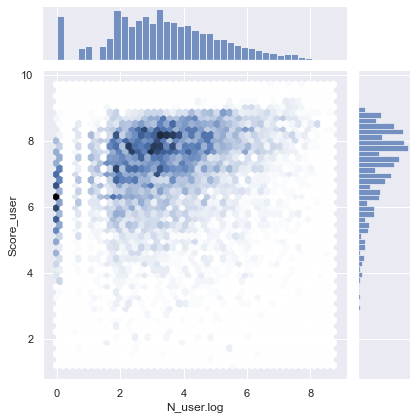

In [23]:
sns.jointplot(data=df, x="N_pro.log", y="Score_pro", kind="hex")
print (df[["N_pro.log", "Score_pro"]].corr())
sns.jointplot(data=df, x="N_user.log", y="Score_user", kind="hex",)
print (df[["N_user.log", "Score_user"]].corr())

           Score_pro  compound
Score_pro    1.00000   0.61534
compound     0.61534   1.00000


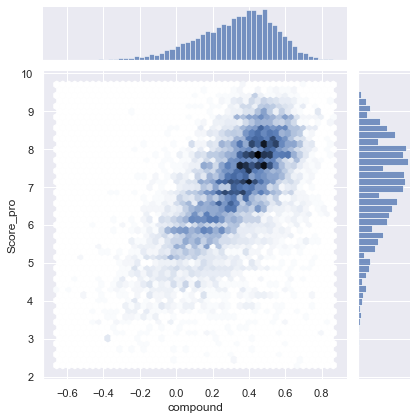

In [24]:
sns.jointplot(data=df, x="compound", y="Score_pro", kind="hex")
print (df[["Score_pro", 'compound']].corr())

### Clustering : how many ?

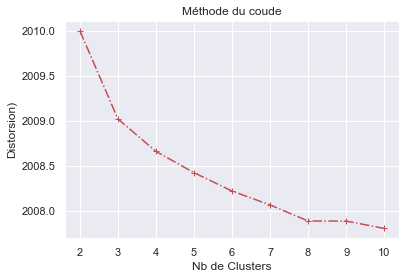

In [25]:
# Importation de la fonction cdist du package scipy.spatial.distance
from scipy.spatial.distance import cdist

col_ = ['Score_pro', 'Score_user',
        'N_pro', 'N_user', 'compound',
        'N_pro.log', 'N_user.log',
        'year','compound',
        'N_pro.log', 'N_user.log',
        'PC', 'nintendo', 'playstation', 'xbox',
       ]  


# Liste des nombre de clusters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]  

# Initialisation de la liste de distorsions
distorsions = []

# Scaling
df2 = df[col_].copy()
scaler = StandardScaler()
scaled_df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

# Calcul des distorsions pour les différents modèles
for n_clusters in range_n_clusters:
    
    # Initialisation d'un cluster ayant un pour nombre de clusters n_clusters
    cluster = KMeans(n_clusters = n_clusters)
    
    # Apprentissage des données suivant le cluster construit ci-dessus
    cluster.fit(df2)
    
    # Ajout de la nouvelle distorsion à la liste des données
    distorsions.append(sum(np.min(cdist(scaled_df2, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(scaled_df2, axis = 0))

plt.figure()
plt.plot(range_n_clusters,distorsions, 'r+-.');
plt.xlabel('Nb de Clusters')
plt.ylabel('Distorsion)')
plt.title('Méthode du coude')
plt.show()


In [26]:
#pd.crosstab(df['oem'], labels, rownames=['OEM'], colnames=['Cluters'])